In [ ]:
# Threading
# To start Julia with 8 threads on PC, open anaconda prompt and run <set JULIA_NUM_THREADS=8>, then run <jupyter notebook>
# ENV["JULIA_NUM_THREADS"] = 8 # Don't need to run on mac - set nthreads in VScode
Threads.nthreads()

8

In [2]:
# import Pkg; Pkg.develop(path="/Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl")
using IRQIV
import PyPlot as plt
import Statistics, NaNStatistics
plt.pygui(true) # sets plots to popup instead of inline

true

In [3]:
# On PC 7/4/24: 
# re-installed IRQIV to desktop since Box installation not syncing to PC, ran Pkg.develop() on new path
# installed same Julia version as on Mac (1.9.3), installed IJulia to sync kernel to Jupyter

In [4]:
# Import images using IRQIV

FLIR_filename = joinpath(raw"/Volumes/ETH_4TB/CNRD_IR/Rec-DeFreesLab_-003504.ats")
# FLIR_filename = joinpath(raw"D:\CNRD_IR\Rec-DeFreesLab_-003504.ats")
Img_dims = [784, 1344]
DtFrames = 1
nImagePairs = Inf

# set range to average over and load images
inds = range(1, step=1, length=500)
raw_imgs = LoadATSImageSequence(FLIR_filename, inds, 2022)

nomean_imgs = zeros(size(raw_imgs))
for img = 1:size(raw_imgs, 3)
    nomean_imgs[:,:,img] = raw_imgs[:,:,img] .- Statistics.mean(raw_imgs[:,:,img])
end

In [5]:
# Visualize frames - SKIP
# Create a plot window and display the initial image
# fig, ax = plt.subplots()
# im = ax.imshow(raw_imgs[1], cmap="viridis", vmin=10000, vmax=10100)

# # Function to update the image
# function update_image!(im, new_img)
#     plt.imshow(new_img, cmap="viridis", vmin=10000, vmax=11000)
#     plt.draw()          # Force an update
#     plt.pause(0.001)
# end

# # Close all existing plot windows (optional, if needed)
# plt.close("all")

# # Update the image in a loop
# for i in 1:length(inds)
#     img = raw_imgs[i]
#     blur_img = zeros(size(raw_imgs[1]))
#     for n = 2:Img_dims[1]-1 # vertical dimension
#         for m = 2:Img_dims[2]-1 # horizontal dimension
#             blur_img[n,m] = Statistics.sum(img[n-1:n+1,m-1:m+1].*1/9)
#         end
#     end
#     update_image!(im, blur_img)
# end

# plt.gcf()

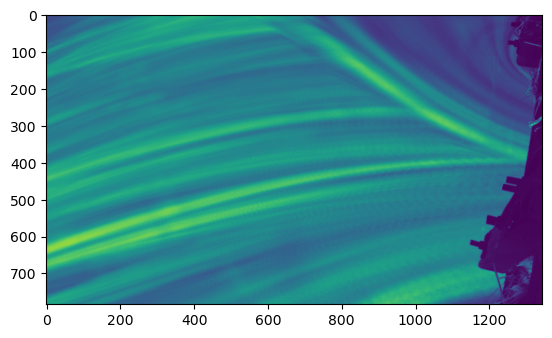

In [6]:
# Pixel-wise std
img_std = dropdims(Statistics.std(nomean_imgs[:,:,:], dims = 3), dims = 3)

# blur_std = zeros(size(img_std))
# for n = 2:Img_dims[1]-1 # vertical dimension
#     for m = 2:Img_dims[2]-1 # horizontal dimension
#         blur_std[n,m] = Statistics.sum(img_std[n-1:n+1,m-1:m+1].*1/9)
#     end
# end

plt.close("all")
plt.imshow(img_std)#, vmin=0, vmax=100)
plt.gcf()

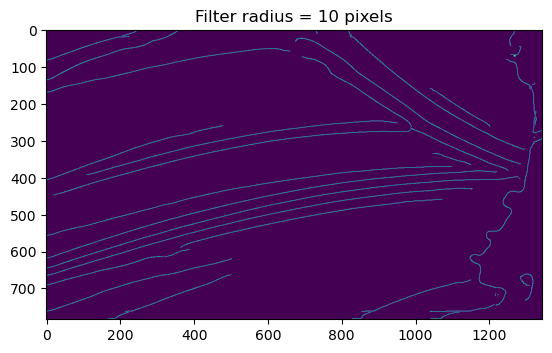

In [7]:
# Edge detection from std dev image
import Images, ImageEdgeDetection
using ImageEdgeDetection: Percentile
filter_rad = 10
alg = ImageEdgeDetection.Canny(spatial_scale=filter_rad, high=Percentile(80), low=Percentile(20))
edges = ImageEdgeDetection.detect_edges(img_std, alg)
# mosaicview(img_std, edges; nrow=1)

# Convert a Float64 matrix to a boolean matrix based on a threshold
function float_to_bool(edges::Matrix{Float64}, threshold::Float64)
    return edges .> threshold
end

# Example usage
edges_bool = float_to_bool(edges, 0.5)

testlinerange = [150:300,50:400]
plt.imshow(edges_bool)#[testlinerange[1],testlinerange[2]])
plt.title("Filter radius = $filter_rad pixels")
plt.gcf()

In [8]:
import Images
import PyPlot as plt

# Custom function to label components with 8-connectivity
function label_components_8_connected(edges::AbstractArray{Bool})
    rows, cols = size(edges)
    labels = zeros(Int, rows, cols)
    current_label = 0
    
    function in_bounds(r, c)
        return 1 <= r <= rows && 1 <= c <= cols
    end
    
    function dfs(r, c, label)
        stack = [(r, c)]
        while !isempty(stack)
            cr, cc = pop!(stack)
            if in_bounds(cr, cc) && edges[cr, cc] && labels[cr, cc] == 0
                labels[cr, cc] = label
                # Add all 8 neighbors
                for dr in -1:1, dc in -1:1
                    if !(dr == 0 && dc == 0)  # skip the current pixel itself
                        push!(stack, (cr + dr, cc + dc))
                    end
                end
            end
        end
    end
    
    for r in 1:rows
        for c in 1:cols
            if edges[r, c] && labels[r, c] == 0
                current_label += 1
                dfs(r, c, current_label)
            end
        end
    end
    
    return labels, current_label
end

# Example usage
# edges = rand(Bool, 256, 256)  # Example: using a random Bool matrix for demonstration
labels, num_components = label_components_8_connected(edges_bool)

# Plot the labeled components
plt.imshow(labels, cmap="nipy_spectral")
plt.colorbar(label="Component Label")
plt.title("Labeled Components with 8-Connectivity")

# Define the diagonal line by two points
ds_shadow_start = [1260, 1]  # [u, v]
ds_shadow_end = [1090, 784]  # [u, v]
plt.plot([ds_shadow_start[1], ds_shadow_end[1]], [ds_shadow_start[2], ds_shadow_end[2]], label="Diagonal Line", linewidth=2.5)
plt.show()


In [9]:
# Generate vector of labeled edges

import ImageMorphology
import Colors

# Assume edges is the boolean matrix from Canny edge detection

function extract_streamline_coords(edges::AbstractArray{Bool})
    # Label connected components
    labels, num_components = label_components_8_connected(edges)
    
    all_streamline_coords = Vector{Vector{Tuple{Int, Int}}}(undef, num_components)
    
    # Iterate over each component and extract coordinates
    for component in 1:num_components
        streamline_coords = Vector{Tuple{Int, Int}}()
        for i in CartesianIndices(edges)
            if labels[i] == component
                push!(streamline_coords, (i[2], i[1])) # j, i
            end
        end
        all_streamline_coords[component] = streamline_coords
    end
    
    return all_streamline_coords
end

# Example usage
all_streamline_coords_canny = extract_streamline_coords(edges_bool)

# all_streamline_coords now contains vectors of coordinates for each continuous line of 1's


61-element Vector{Vector{Tuple{Int64, Int64}}}:
 [(728, 1), (728, 2), (729, 2), (730, 2), (731, 2), (731, 3), (732, 4), (732, 5), (733, 6), (733, 7), (733, 8), (734, 8), (734, 9), (734, 10), (735, 10), (735, 11), (735, 12), (735, 13)]
 [(206, 19), (207, 19), (208, 19), (209, 19), (210, 18), (211, 18), (212, 18), (213, 17), (213, 18), (214, 17)  …  (282, 2), (283, 2), (284, 2), (285, 2), (286, 2), (287, 2), (288, 2), (289, 2), (290, 2), (291, 2)]
 [(1, 139), (2, 138), (2, 139), (3, 138), (4, 138), (5, 137), (5, 138), (6, 137), (7, 137), (8, 137)  …  (374, 2), (375, 2), (376, 2), (377, 2), (378, 2), (379, 2), (380, 2), (381, 2), (382, 2), (383, 2)]
 [(805, 2), (806, 2), (807, 2), (808, 2), (809, 2), (810, 2), (811, 2), (812, 2), (813, 2), (814, 2)  …  (824, 15), (825, 15), (825, 16), (826, 16), (827, 16), (827, 17), (827, 18), (828, 18), (828, 19), (829, 19)]
 [(1267, 14), (1267, 15), (1268, 12), (1268, 13), (1268, 14), (1269, 9), (1269, 10), (1269, 11), (1269, 12), (1270, 7), (1270, 8),

In [10]:
# Function definitions - line identification

# Define the meshgrid function
function meshgrid(x::AbstractVector, y::AbstractVector)
    X = repeat(x', length(y), 1)
    Y = repeat(y, 1, length(x))
    return X, Y
end

# Bresenham's line algorithm to get pixels for a line
function bresenham_line(x0, y0, x1, y1)
    pixels = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = x0 < x1 ? 1 : -1
    sy = y0 < y1 ? 1 : -1
    err = dx - dy

    while true
        push!(pixels, (x0, y0))
        if x0 == x1 && y0 == y1
            break
        end
        e2 = 2 * err
        if e2 > -dy
            err -= dy
            x0 += sx
        end
        if e2 < dx
            err += dx
            y0 += sy
        end
    end
    return pixels
end

# Wu's antialiasing algorithm - returns a raster along line w/ varying pixel intensities (smoothing effect)
function wu_line(x0, y0, x1, y1)
    function plot(x, y, c)
        return (x, y, c)
    end

    function ipart(x)
        return floor(Int, x)
    end

    function round(x)
        return ipart(x + 0.5)
    end

    function fpart(x)
        return x - floor(x)
    end

    function rfpart(x)
        return 1 - fpart(x)
    end

    steep = abs(y1 - y0) > abs(x1 - x0)

    if steep
        x0, y0 = y0, x0
        x1, y1 = y1, x1
    end

    if x0 > x1
        x0, x1 = x1, x0
        y0, y1 = y1, y0
    end

    dx = x1 - x0
    dy = y1 - y0
    gradient = dy / dx

    xend = round(x0)
    yend = y0 + gradient * (xend - x0)
    xgap = rfpart(x0 + 0.5)
    xpxl1 = xend
    ypxl1 = ipart(yend)
    pixels = [
        plot(xpxl1, ypxl1, rfpart(yend) * xgap),
        plot(xpxl1, ypxl1 + 1, fpart(yend) * xgap)
    ]

    intery = yend + gradient

    xend = round(x1)
    yend = y1 + gradient * (xend - x1)
    xgap = fpart(x1 + 0.5)
    xpxl2 = xend
    ypxl2 = ipart(yend)
    push!(pixels, plot(xpxl2, ypxl2, rfpart(yend) * xgap))
    push!(pixels, plot(xpxl2, ypxl2 + 1, fpart(yend) * xgap))

    for x in (xpxl1 + 1):(xpxl2 - 1)
        push!(pixels, plot(x, ipart(intery), rfpart(intery)))
        push!(pixels, plot(x, ipart(intery) + 1, fpart(intery)))
        intery += gradient
    end

    if steep
        pixels = [(y, x, c) for (x, y, c) in pixels]
    end

    return pixels
end

wu_line (generic function with 1 method)

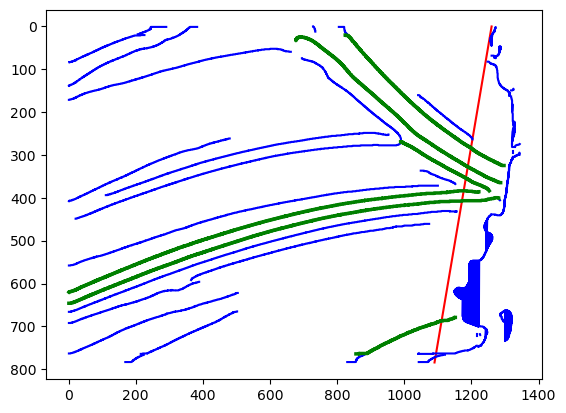

In [11]:
import LinearAlgebra
import PyPlot as plt


# Function to check if a streamline intersects the diagonal line
function check_intersections(ds_shadow_start, ds_shadow_end, all_streamline_coords, length_threshold)
    # Call bresenham_line to generate pixel coordinates along the diagonal line
    line_coords = bresenham_line(ds_shadow_start[1], ds_shadow_start[2], ds_shadow_end[1], ds_shadow_end[2])
    
    # Initialize a vector to hold the intersecting streamlines
    intersecting_streamlines = []
    
    # Loop through each set of streamline coordinates
    for streamline_coords in all_streamline_coords
        # Calculate the length of the streamline
        streamline_length = LinearAlgebra.norm(streamline_coords[end] .- streamline_coords[1])
        
        # Only check streamlines that exceed the length threshold
        if streamline_length >= length_threshold
            # Check if any of the streamline coordinates intersect with the diagonal line
            for line_pix in line_coords
                if line_pix in streamline_coords
                    push!(intersecting_streamlines, streamline_coords)
                    break  # Stop checking this streamline if an intersection is found
                end
            end
        end
    end
    
    return intersecting_streamlines, line_coords
end


# Set a length threshold (e.g., 100 pixels)
length_threshold = 200

# Find streamlines that intersect with the diagonal line
intersecting_streamlines, bayside_line_coords = check_intersections(ds_shadow_start, ds_shadow_end, all_streamline_coords_canny, length_threshold)
intersecting_streamlines

# Optional: Plot the diagonal line and the intersecting streamlines
fig, ax = plt.subplots()

# Plot the diagonal line
ax.plot([ds_shadow_start[1], ds_shadow_end[1]], [ds_shadow_start[2], ds_shadow_end[2]], "r-", label="Diagonal Line")

# Plot all streamlines
for streamline_coords in all_streamline_coords_canny
    x_coords = [coord[1] for coord in streamline_coords]
    y_coords = [coord[2] for coord in streamline_coords]
    
    ax.plot(x_coords, y_coords, "b-", label="Streamline")
    ax.invert_yaxis()
end

# Highlight intersecting streamlines
for streamline_coords in intersecting_streamlines
    x_coords = [coord[1] for coord in streamline_coords]
    y_coords = [coord[2] for coord in streamline_coords]
    
    ax.plot(x_coords, y_coords, "g-", label="Intersecting Streamline", linewidth=2.5)
    ax.invert_yaxis()
end

plt.gcf()

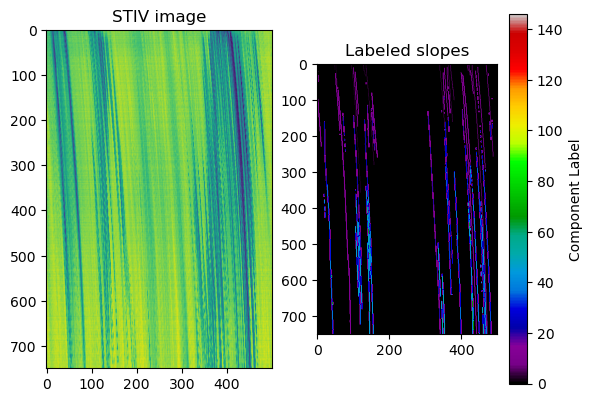

In [12]:
# STIV test with variance streamline - manually select component
test_edge_pix = all_streamline_coords_canny[42] # Long streamline from edge of image to just before entrance
STIV_vec_Canny = zeros(length(test_edge_pix), length(raw_imgs))

# Create STIV image
for img = 1:length(raw_imgs)
    for coord = 1:length(test_edge_pix)
        j, i = test_edge_pix[coord]
        STIV_vec_Canny[coord, img] = raw_imgs[i, j, img]
    end
end

STIV_edges = ImageEdgeDetection.detect_edges(STIV_vec_Canny, alg)
STIV_edges = float_to_bool(STIV_edges, 0.5)
STIV_labels, num_components = label_components_8_connected(STIV_edges)

fig, (ax1, ax2) = plt.subplots(1, 2)
im1 = ax1.imshow(STIV_vec_Canny)
ax1.set_title("STIV image")
im2 = ax2.imshow(STIV_labels, cmap="nipy_spectral")
ax2.set_title("Labeled slopes")
fig.colorbar(im2, ax=ax2, label="Component Label")
plt.gcf()


In [13]:
# Function to calculate the slope of each labeled component if it exceeds the length threshold
function calculate_slope_for_components(labels::AbstractArray{Int}, num_components::Int; length_threshold::Int=100)
    slopes = Dict{Int, Float64}()
    
    for label in 1:num_components
        # Find the coordinates of all pixels in the component
        component_coords = findall(x -> x == label, labels)
        
        # Only consider the component if it exceeds the length threshold
        if length(component_coords) > length_threshold
            # Find the first and last pixel coordinates in the component
            first_pixel = component_coords[1]
            last_pixel = component_coords[end]
            
            # Calculate the slope between the first and last pixel
            x1, y1 = first_pixel[2], first_pixel[1]  # (x1, y1)
            x2, y2 = last_pixel[2], last_pixel[1]    # (x2, y2)
            
            if x2 != x1
                slope = (y2 - y1) / (x2 - x1)
            else
                slope = Inf  # Vertical line (undefined slope)
            end
            
            # Store the slope in a dictionary
            slopes[label] = slope
        end
    end
    
    return slopes
end


calculate_slope_for_components (generic function with 1 method)

In [1]:
plt.close("all")

# Loop through all intersecting streamlines and calculate STIV slope

# Preallocate for storing slopes
STIV_averages = zeros(length(intersecting_streamlines))
STIV_line_limit = 200
loop = 1

for streamline_coords in intersecting_streamlines
 # Locate the intersection index for trimming
    intersection_idx = findfirst(p -> p in bayside_line_coords, streamline_coords)
    if intersection_idx !== nothing
        # Calculate upstream coordinates with limits to avoid out-of-bounds errors
        start_idx = max(1, intersection_idx - STIV_line_limit)
        upstream_coords = start_idx:intersection_idx
        trimmed_streamline = streamline_coords[upstream_coords]

        # Continue with STIV image processing using trimmed_streamline
        STIV_vec = zeros(length(trimmed_streamline), length(raw_imgs))
        
        # Extract pixel values for the trimmed streamline across the image time series
        for img = 1:size(nomean_imgs, 3)
            for coord = 1:length(trimmed_streamline)
                j, i = trimmed_streamline[coord]
                STIV_vec[coord, img] = nomean_imgs[i, j, img] # (i, j) for row, col order
            end
        end

        # Perform edge detection on the STIV image
        STIV_edges = ImageEdgeDetection.detect_edges(STIV_vec, alg)
        STIV_edges = float_to_bool(STIV_edges, 0.5)

        # Label connected components in the detected edges
        STIV_labels, num_components = label_components_8_connected(STIV_edges)

        # Calculate slope for components over a length threshold (e.g. 100 pixels)
        STIV_slopes = calculate_slope_for_components(STIV_labels, num_components, length_threshold=100)
        STIV_averages[loop] = Statistics.mean(values(STIV_slopes)) # Stored as a dictionary

        # Plot the results
        x_coords = [coord[1] for coord in trimmed_streamline]  # x = col index
        y_coords = [coord[2] for coord in trimmed_streamline]  # y = row index
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

        # Plot the original image with the streamline
        im1 = ax1.imshow(img_std, cmap="viridis")  # Show the first frame or another reference image
        ax1.plot(x_coords, y_coords, "r", linewidth=2.5)  # Overlay the streamline in red
        ax1.set_title("Streamline")
        
        # Plot the STIV image
        im2 = ax2.imshow(STIV_vec, cmap="viridis")  # Display STIV vector
        ax2.set_title("STIV Image")
        
        # Plot the labeled components (slope map)
        im3 = ax3.imshow(STIV_labels, cmap="nipy_spectral")
        ax3.set_title("Labeled Slopes")
        fig.colorbar(im3, ax=ax3, label="Component Label")

        fig.suptitle("STIV Average Slope: $(round(STIV_averages[loop], 3))", fontsize=14)
        plt.gcf()  # Display the plot
    end

    loop += 1
end

plt.show()

UndefVarError: UndefVarError: `plt` not defined

┌ Warning: thread = 1 warning: parsed expected 6 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV /Users/evanheberlein/.julia/packages/CSV/OnldF/src/file.jl:578


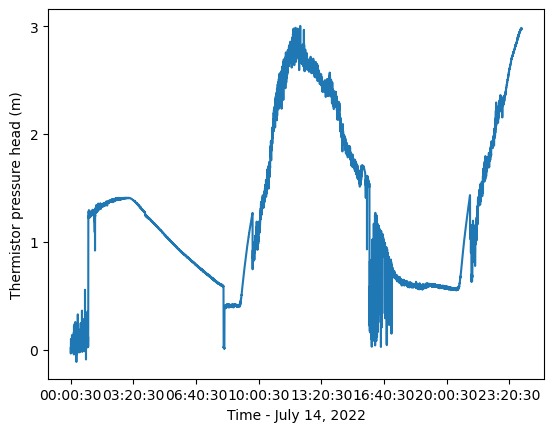

In [23]:
# INCORPORATE GEOREFERENCING - downstream
import CSV, Dates, Geodesy
using DataFrames
ft_to_m = 0.3048

macpath = raw"/Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/2023/5_23_SiteVisit/Georeferencing/Leica/M_CNRD.TXT"
winpath = raw"C:\Users\evanh\Box\Cornell\CACO\2023\5_23_SiteVisit\Georeferencing\Leica\M_CNRD.TXT"
ft_to_m = 0.3048
CNRD_resurvey = CSV.read(macpath, DataFrames.DataFrame) # Total station recorded in survey ft!!
US_GCP_xyz_resurvey = [CNRD_resurvey[2:7,2] CNRD_resurvey[2:7,3] CNRD_resurvey[2:7,4]] .* ft_to_m
DS_GCP_xyz_resurvey = [CNRD_resurvey[8:12,2] CNRD_resurvey[8:12,3] CNRD_resurvey[8:12,4]] .* ft_to_m

# Convert to geospatial coords using GPS data
antenna_csv = CSV.read(raw"/Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/2023/5_23_SiteVisit/Georeferencing/InertialSense/20230515_173251_base/LOG_SN40107_20230515_173251_0001_DID_GPS1_RTK_POS.csv", DataFrames.DataFrame)
antenna_lla = Geodesy.LLA(Statistics.mean(antenna_csv."lla[0]"), Statistics.mean(antenna_csv."lla[1]"), Statistics.mean(antenna_csv."lla[2]"))
antenna_utm = Geodesy.UTMZ(antenna_lla, Geodesy.wgs84)

# US_GCP_utm_resurvey = US_GCP_xyz_resurvey + [antenna_utm.x antenna_utm.y antenna_utm.z]
US_GCP_utm_resurvey = US_GCP_xyz_resurvey .+ [antenna_utm.x antenna_utm.y antenna_utm.z] # Add UTM position of antenna to all relative points in m
DS_GCP_utm_resurvey = DS_GCP_xyz_resurvey .+ [antenna_utm.x antenna_utm.y antenna_utm.z] # Add UTM position of antenna to all relative points in m

# Set x&y location of all bolts on post 5 to same location (vertically-aligned)
# DS_GCP_utm_resurvey[2, 1:2] = DS_GCP_utm_resurvey[1, 1:2]
# DS_GCP_utm_resurvey[3, 1:2] = DS_GCP_utm_resurvey[1, 1:2]
US_GCP_utm_resurvey

# Thermistor data 
thermpath = raw"/Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/2022/Thermistor/P6_CACO_July_2022_truncated.txt"
therm = CSV.read(thermpath, delim = ',', DataFrame)
thermP = therm[:,2] # water surface elevation from thermistor - in dbar?
# # 360 lines per hour, 8640 lines per day
us_therm_cam_offset = (sqrt(9^2-2^2) + 1/3 + 7) * ft_to_m
ds_therm_cam_offset = 209/12*ft_to_m

therm[!,3] = Dates.Date.(therm[!,3], " dd u YYYY")
therm_datetime = Dates.DateTime.(therm[!,3], therm[!,4])
therm = hcat(therm, therm_datetime)
rename!(therm,[:TemperatureC, :PressureM, :Date, :Time, :DateTime])

therm_moved_bool = (therm.Time .== Dates.Time("08:12:00", "HH:MM:SS")) .& (therm.Date .== Dates.Date("2022-07-14", "yyyy-mm-dd"))
therm_moved_idx = findall(x->x==1, therm_moved_bool)
thermZ = us_therm_cam_offset.-thermP[1:therm_moved_idx[]] # vertical offset from camera to thermistor - 
thermZ = append!(thermZ, ds_therm_cam_offset.-thermP[therm_moved_idx[]+1:end])

therm = hcat(therm, thermZ)
rename!(therm, :x1 => :WaterDistanceFromCameraM)

plt.close("all")
thermT = string.(therm[:,4])
plt.plot(thermT[6302:6302+8638], thermP[6302:6302+8638])
plt.xticks(1:1200:length(thermZ[6302:6302+8638])#, rotation = 45
)
plt.xlabel("Time - July 14, 2022")
plt.ylabel("Thermistor pressure head (m)")
plt.rc("font",size=24)
plt.gcf()

In [24]:
# Global camera parameters
fl = 1214.2857142857144 # In pixels - from Seth
include(raw"/Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl")
Camera = IRQIV.FLIR_SC8303_17mm
ι = IRQIV.IntrinsicCalibrationParameters(Camera)

IntrinsicCalibrationParameters(672.5, 392.5, 1.0086485610865155, 1.0, 1.4e-5, [1.0, 3.0, 5.0], [0.020522291524825344, -3.156396095419575e-8, -8.859823756718999e-14])

In [25]:
import Geodesy

# Incorporate board georef on DOWNSTREAM side:
DS_board_o1 = CSV.read(raw"/Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/2022/CACO_GPS/20220714_201935_DS_GCPo1/LOG_SN40107_20220714_201935_0001_DID_GPS1_POS.csv", DataFrame)
DS_board_o1 = DS_board_o1[:,[9, 10, 11, 16]] # lla 1-3 + status (code 0x00000C00 = RTK_FIX according to pg. 138: https://docs.inertialsense.com/user-manual/reference/user_manual_pdf/InertialSenseDocs.pdf)
DS_board_o1_fix = filter(row->any(occursin.("C", row.status[end-2:end-2])), DS_board_o1) # from https://discourse.julialang.org/t/better-way-to-filter-strings-from-dataframe/88012
DS_board_o4 = CSV.read(raw"/Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/2022/CACO_GPS/20220714_210002_DS_GCPo4/LOG_SN40107_20220714_210002_0001_DID_GPS1_POS.csv", DataFrame)
DS_board_o4 = DS_board_o4[:,[9, 10, 11, 16]] 
DS_board_o4_fix = filter(row->any(occursin.("C", row.status[end-2:end-2])), DS_board_o4) 
DS_board_o5 = CSV.read(raw"/Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/2022/CACO_GPS/20220714_211156_DS_GCPo5/LOG_SN40107_20220714_211156_0001_DID_GPS1_POS.csv", DataFrame)
DS_board_o5 = DS_board_o5[:,[9, 10, 11, 16]] 
DS_board_o5_fix = filter(row->any(occursin.("C", row.status[end-2:end-2])), DS_board_o5) 

# o4 & o5 did not get to RTK_FIX but still look very steady - average!
# plt.close("all")
# plt.plot(DS_board_o1_fix[:,1])
# #plt.plot(DS_board_o1_fix[:,2])
# #plt.plot(DS_board_o1_fix[:,3])
# plt.plot(DS_board_o4[:,1])
# #plt.plot(DS_board_o4[:,2])
# #plt.plot(DS_board_o4[:,3])
# plt.plot(DS_board_o5[:,1])
# #plt.plot(DS_board_o5[:,2])
# #plt.plot(DS_board_o5[:,3])
# plt.show()

# Check drift of non-fix GPS 
maximum(DS_board_o4[:,1]) - minimum(DS_board_o4[:,1])
maximum(DS_board_o4[:,2]) - minimum(DS_board_o4[:,2])
maximum(DS_board_o4[:,3]) - minimum(DS_board_o4[:,3])
maximum(DS_board_o5[:,1]) - minimum(DS_board_o5[:,1])
maximum(DS_board_o5[:,2]) - minimum(DS_board_o5[:,2])
maximum(DS_board_o5[:,3]) - minimum(DS_board_o5[:,3])
# Drift is minimal in x/y but large in z

# Compare averages/minimums
DS_board_o1_avg = Statistics.mean.(eachcol(DS_board_o1_fix[:,1:3]))
DS_board_o4_avg = Statistics.mean.(eachcol(DS_board_o4[:,1:3]))
DS_board_o5_avg = Statistics.mean.(eachcol(DS_board_o5[:,1:3]))
DS_board_o5_avg[3] = minimum(DS_board_o5[:,3])
dump(DS_board_o1_avg[3])
dump(DS_board_o4_avg[3])
dump(DS_board_o5_avg[3])
# o5 minimum is closer to mean of o1 & o4, numbers look reasonable relative to DS_GCP_utm_resurvey

# Convert LLA to UTM
DS_board_o1_utm = Geodesy.UTMZ(Geodesy.LLA(DS_board_o1_avg[1], DS_board_o1_avg[2], DS_board_o1_avg[3]), Geodesy.wgs84)
DS_board_o4_utm = Geodesy.UTMZ(Geodesy.LLA(DS_board_o4_avg[1], DS_board_o4_avg[2], DS_board_o4_avg[3]), Geodesy.wgs84)
DS_board_o5_utm = Geodesy.UTMZ(Geodesy.LLA(DS_board_o5_avg[1], DS_board_o5_avg[2], DS_board_o5_avg[3]), Geodesy.wgs84)
DS_board_utm = [DS_board_o1_utm.x DS_board_o1_utm.y DS_board_o1_utm.z
DS_board_o4_utm.x DS_board_o4_utm.y DS_board_o1_utm.z
DS_board_o5_utm.x DS_board_o5_utm.y DS_board_o1_utm.z]

# Add board GPS to resurvey vector:
DS_GCP_utm_combined = vcat(DS_GCP_utm_resurvey, DS_board_utm[1,:]')

# plt.close("all")
# plt.scatter(DS_GCP_utm_combined[:,1], DS_GCP_utm_combined[:,2])
# plt.show()

Float64 -25.947234686018657
Float64 -26.080654823149864
Float64 -26.143906926736236


6×3 Matrix{Float64}:
      4.11745e5  4.64267e6  -25.1365
      4.11745e5  4.64267e6  -25.5898
      4.11745e5  4.64267e6  -26.0746
      4.11744e5  4.64268e6  -26.2701
 411744.0        4.64268e6  -27.268
      4.11743e5  4.64267e6  -25.9472

In [26]:
# Camera location calibration setup - DOWNSTREAM SIDE:
camll_ds = [41.931099, -70.064524] # Guess from Google maps
# Have measurement of camera to deck (?) for US side
camelev_ds = DS_GCP_utm_resurvey[3,3] + 6.5*ft_to_m # Use lower bolt elevation w/ offset - [old: Guess DS camera offset from board GCP elev based on photos]
cam_LLA_ds = Geodesy.LLA(camll_ds[1], camll_ds[2], camelev_ds)
cam_UTM_ds = Geodesy.UTMZ(cam_LLA_ds, Geodesy.wgs84)

# Camera angle approximation:
azimuth_ds = 315 * (pi/180)  # Guess from google maps
tilt_ds = atan(34/120) # atan(120/34)  # Approx. from photo
roll_ds = atan(7/50) # ''

# Initial guess of camera's extrinsic parameters:
χinitial_ds = IRQIV.ExtrinsicCalibrationParameters(azimuth_ds, tilt_ds, roll_ds, fl, cam_UTM_ds.x, cam_UTM_ds.y, cam_UTM_ds.z)
dump(χinitial_ds)

# UTM coordinates of GCPs:
# TrueGCPxyz = [GCPxyz_us[:,1] GCPxyz_us[:,2] GCPzg_us]

# Pixel coordinates of GCPs, before accounting for radial distortion:
# File 3582 can see bolt without grass in the way
DistortedImageGCPuv_ds  = [1255 443 # 5H
                        1200 549 # 5M
                        1155 615 # 5L
                        1257 73 # 6H
                        1278 264 # 6L
                        606 71] # board o1
                        #516 366 # board o4
                        #388 716] # board o5


TrueGCPuv_ds = hcat(IRQIV.RemoveRadialDistortion(DistortedImageGCPuv_ds[:,1], DistortedImageGCPuv_ds[:,2], Camera)...)

# FLIR_filename_ds = joinpath(raw"/Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO_backup/2022/CNRD_IR/Rec-DeFreesLab_-003447.ats")
# IRimages_ds = LoadATSImageSequence(FLIR_filename_ds, 1, 2022)
# plt.close("all")
# GraphicallyExploreInitialCalibrationGuess(TrueGCPuv_ds, DS_GCP_utm_combined, χinitial_ds, ι, IRimages_ds[1])
# plt.show()

ExtrinsicCalibrationParameters
  φ: Float64 5.497787143782138
  τ: Float64 0.27609701939543646
  σ: Float64 0.13909594148207133
  f: Float64 1214.2857142857144
  x_c: Float64 411743.0601037771
  y_c: Float64 4.642674180709229e6
  z_c: Float64 -24.093384677637545


6×2 Matrix{Float64}:
 1255.36  443.031
 1198.5   548.555
 1152.8   613.988
 1263.39   69.5088
 1280.77  263.412
  607.07   76.1732

In [27]:
# Camera location calibration - DOWNSTREAM SIDE:
dlt_ds = IRQIV.DLT(χinitial_ds, FLIR_SC8303_17mm)
###############################################################################

χcalculated_ds = ExtrinsicCalibration(
    TrueGCPuv_ds,
    DS_GCP_utm_combined,
    χinitial_ds,
    ι,
    MaxIterations = 50,
    PrintoutStats=true)

# ###############################################################################
@info "Initial guess, χinitial:"
@show dump(χinitial_ds)
# 
@info "Calibrated values, χcalculated:"
@show dump(χcalculated_ds)
# 
# Describe how much the calibration changed each parameter:
@info "Difference between calibrated value and initial guess:"
for (i,x) in enumerate(fieldnames(typeof(χcalculated_ds)))
    if i <= 3
        println("$x diff (degrees) -  $(rad2deg(getfield(χinitial_ds, x) - getfield(χcalculated_ds, x)))")
    elseif i == 4
        println("$x diff -  $(getfield(χinitial_ds, x) - getfield(χcalculated_ds, x))")
    else
        println("$x diff (meters) -  $(getfield(χinitial_ds, x) - getfield(χcalculated_ds, x))")
    end
end

# plt.close("all")
# GraphicallyExploreInitialCalibrationGuess(TrueGCPuv_ds, DS_GCP_utm_combined, χcalculated_ds, ι, IRimages_ds[1])
# plt.show()

Finished extrinsic calibration:, 21 iterations, max(|ε|)=2e-10, rms(ε₁-ε₀)=1e-10
ExtrinsicCalibrationParameters
  φ: Float64 5.497787143782138
  τ: Float64 0.27609701939543646
  σ: Float64 0.13909594148207133
  f: Float64 1214.2857142857144
  x_c: Float64 411743.0601037771
  y_c: Float64 4.642674180709229e6
  z_c: Float64 -24.093384677637545
dump(χinitial_ds) = nothing
ExtrinsicCalibrationParameters
  φ: Float64 7.568765839436635
  τ: Float64 2.479015325984377
  σ: Float64 4.091954295923226
  f: Float64 665.1389092858687
  x_c: Float64 411744.6871920161
  y_c: Float64 4.64267437165379e6
  z_c: Float64 -24.684111561614657
dump(χcalculated_ds) = nothing
φ diff (degrees) -  -118.65833872251088
τ diff (degrees) -  -126.21792157965261
σ diff (degrees) -  -226.4821007225058
f diff -  549.1468049998457
x_c diff (meters) -  -1.6270882390090264
y_c diff (meters) -  -0.190944560803473
z_c diff (meters) -  0.590726883977112


┌ Info: Initial guess, χinitial:
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/CACO_git/CACO_22_jl/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X24sZmlsZQ==.jl:14
┌ Info: Calibrated values, χcalculated:
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/CACO_git/CACO_22_jl/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X24sZmlsZQ==.jl:17
┌ Info: Difference between calibrated value and initial guess:
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/CACO_git/CACO_22_jl/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X24sZmlsZQ==.jl:21


  0.005325 seconds (45.75 k allocations: 4.538 MiB)
Geotransform: [411722.39502338204, 0.010663243384925926, 0.0, 4.6427032177e6, 0.0, -0.010663243384925926]
Projection: PROJCS["WGS 84 / UTM zone 19N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-69],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32619"]]


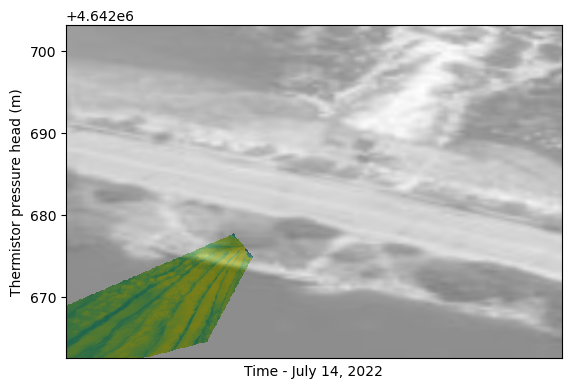

In [28]:
# Test reprojection against basemap imagery

# ChatGPT function to find nearest thermistor times to each
function find_nearest_time_indices(irregular_times, regular_times)
    nearest_indices = [argmin(abs.(time .- regular_times)) for time in irregular_times]
    return nearest_indices
end

# Extract WSE from thermistor time series using ATS file timestamp
ATS_file_time_ds = IRQIV.ats_ts(raw_imgs)
therminds_ds = find_nearest_time_indices(ATS_file_time_ds, therm.DateTime)
WSE_mean_ATS_ds = χcalculated_ds.z_c - therm.WaterDistanceFromCameraM[therminds_ds][1]
RectParams_ds = IRQIV.ImageRectification.calculate_image_rectification(Camera.pixel_resolution, ι, χcalculated_ds, WSE_mean_ATS_ds, interpolated_grid_spacing=0.1)
rectified_image_ds = RectParams_ds(raw_imgs)

import ArchGDAL
basemap_path = ArchGDAL.read(raw"/Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/2022/Analysis/Bing_basemap_CNRD_UTM_tighter.tif")
basemap_band = ArchGDAL.getband(basemap_path, 1)
basemap = ArchGDAL.read(basemap_band)

# Get the geotransform (affine transformation to map pixel coordinates to world coordinates)
geotransform = ArchGDAL.getgeotransform(basemap_path)

# Get the dimensions of the image
width = ArchGDAL.width(basemap_path)
height = ArchGDAL.height(basemap_path)

# Extract the geotransform values
x_min = geotransform[1]
y_max = geotransform[4]
x_res = geotransform[2]  # Pixel width
y_res = geotransform[6]  # Pixel height (negative)

# Calculate the extents
x_max = x_min + width * x_res
y_min = y_max + height * y_res

# Extent for imshow
basemap_extent = (x_min, x_max, y_min, y_max)

# Get the projection (coordinate system)
projection = ArchGDAL.getproj(basemap_path)

println("Geotransform: ", geotransform)
println("Projection: ", projection)

plt.imshow(rectified_image_ds, extent=RectParams_ds.extent)
plt.imshow(basemap, extent=basemap_extent, alpha = 0.5, cmap = "gray")
plt.gcf()

In [29]:
# UPSTREAM TEST - VARIANCE STREAMLINE


FLIR_filename = joinpath(raw"/Volumes/ETH_4TB/CNRD_IR/Rec-DeFreesLab_-003365.ats")
raw_imgs = LoadATSImageSequence(FLIR_filename, inds, 2022) # Same parameters as downstream (500 frames)

# Pixel-wise std
img_std = dropdims(Statistics.std(raw_imgs[:,:,:], dims = 3), dims = 3)

plt.figure()
plt.imshow(img_std)#, vmin=0, vmax=100)

# Edge detection from std dev image
filter_rad = 10
alg = ImageEdgeDetection.Canny(spatial_scale=filter_rad, high=Percentile(80), low=Percentile(20))
edges = ImageEdgeDetection.detect_edges(img_std, alg)

# Example usage
threshold = 0.5  # Define an appropriate threshold value
edges_bool = float_to_bool(edges, threshold)

plt.figure()
plt.imshow(edges_bool)#[testlinerange[1],testlinerange[2]])
plt.title("spatial scale = $filter_rad")

edges_bool = float_to_bool(edges, threshold)
labels, num_components = label_components_8_connected(edges_bool)

# Plot the labeled components
plt.figure()
plt.imshow(labels, cmap="nipy_spectral")
plt.colorbar(label="Component Label")
plt.title("Labeled Components with 8-Connectivity")
us_shadow_start = [182,1] # [u,v]
us_shadow_end = [764,784] # [u,v]
plt.plot([us_shadow_start[1], us_shadow_end[1]], [us_shadow_start[2], us_shadow_end[2]], label="Diagonal Line", linewidth=2.5)
plt.gcf()

all_streamline_coords_canny = extract_streamline_coords(edges_bool)

test_edge_pix = all_streamline_coords_canny[92] # Long streamline from edge of image to just before entrance
STIV_vec_Canny = zeros(length(test_edge_pix), length(raw_imgs))

for img = 1:length(raw_imgs)
    for coord = 1:length(test_edge_pix)
        j, i = test_edge_pix[coord]
        STIV_vec_Canny[coord, img] = raw_imgs[i, j, img]
    end
end




UndefVarError: UndefVarError: `label_components_8_connected` not defined

In [30]:
plt.figure()
plt.imshow(labels, cmap="nipy_spectral")
plt.colorbar(label="Component Label")
plt.title("Labeled Components with 8-Connectivity")
us_shadow_start = [182,1] # [u,v]
us_shadow_end = [764,784] # [u,v]
plt.plot([us_shadow_start[1], us_shadow_end[1]], [us_shadow_start[2], us_shadow_end[2]], label="Diagonal Line", linewidth=2.5)
plt.show()

UndefVarError: UndefVarError: `labels` not defined

In [31]:
length_threshold = 200

# Find streamlines that intersect with the diagonal line
intersecting_streamlines = check_intersections(us_shadow_start, us_shadow_end, all_streamline_coords_canny, length_threshold)


UndefVarError: UndefVarError: `check_intersections` not defined

In [32]:
plt.close("all")

# Loop through all intersecting streamlines and calculate STIV slope

# Preallocate for storing slopes
STIV_averages = zeros(length(intersecting_streamlines))
loop = 1

for streamline_coords in intersecting_streamlines
    # Create STIV vector for each streamline across all images
    STIV_vec = zeros(length(streamline_coords), size(nomean_imgs, 3))

    # Extract pixel values for the streamline across the image time series
    for img = 1:size(nomean_imgs, 3)
        for coord = 1:length(streamline_coords)
            j, i = streamline_coords[coord]
            STIV_vec[coord, img] = nomean_imgs[i, j, img] # i, j (row, col) should be correct order
        end
    end

    # Perform edge detection on the STIV image
    STIV_edges = ImageEdgeDetection.detect_edges(STIV_vec, alg)
    STIV_edges = float_to_bool(STIV_edges, 0.5)

    # Label connected components in the detected edges
    STIV_labels, num_components = label_components_8_connected(STIV_edges)

    # Calculate slope for components over a length threshold (e.g. 100 pixels)
    STIV_slopes = calculate_slope_for_components(STIV_labels, num_components, length_threshold=100)
    STIV_averages[loop] = Statistics.mean(values(STIV_slopes)) # Stored as a dictionary

    # Plot the results
    x_coords = [coord[1] for coord in streamline_coords]  # x = col index
    y_coords = [coord[2] for coord in streamline_coords]  # y = row index
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the original image with the streamline
    im1 = ax1.imshow(img_std, cmap="viridis")  # Show the first frame or another reference image
    ax1.plot(x_coords, y_coords, "r", linewidth=2.5)  # Overlay the streamline in red
    ax1.set_title("Streamline")
    
    # Plot the STIV image
    im2 = ax2.imshow(STIV_vec, cmap="viridis")  # Display STIV vector
    ax2.set_title("STIV Image")
    
    # Plot the labeled components (slope map)
    im3 = ax3.imshow(STIV_labels, cmap="nipy_spectral")
    ax3.set_title("Labeled Slopes")
    fig.colorbar(im3, ax=ax3, label="Component Label")

    fig.suptitle("STIV Average Slope: $(STIV_averages[loop])", fontsize=14)
    plt.gcf()  # Display the plot

    loop += 1
end

plt.show()

UndefVarError: UndefVarError: `intersecting_streamlines` not defined

In [33]:
# Camera location calibration setup - UPSTREAM SIDE:
camll_us = [41.931168, -70.064190] # Guess from google maps
camelev_us = sqrt(9^2-2^2)*ft_to_m + (US_GCP_utm_resurvey[1,3] * ft_to_m) # add elevation from bridge deck to elevation of first bolt below deck (~4" off?)
cam_LLA_us = Geodesy.LLA(camll_us[1], camll_us[2], camelev_us)
cam_UTM_us = Geodesy.UTMZ(cam_LLA_us, Geodesy.wgs84)

# Camera angle approximation:
azimuth_us = deg2rad(5) # Guess from google maps
# azimuth_us = deg2rad(5-40) # CONVERGE #1
tilt_us = atan(70/62) # Approx. from photo
# tilt_us = atan(70/62 - deg2rad(55)) # CONVERGE #1
roll_us = atan(20/85) # ''
# roll_us = atan(20/85 + deg2rad(45)) # CONVERGE #1

# Initial guess of camera's extrinsic parameters:
χinitial_us = IRQIV.ExtrinsicCalibrationParameters(azimuth_us, tilt_us, roll_us, fl, cam_UTM_us.x, cam_UTM_us.y, cam_UTM_us.z) # can also play with height
# χinitial = IRQIV.ExtrinsicCalibrationParameters(azimuth_us, tilt_us, roll_us, fl, cam_UTM_us.x-1, cam_UTM_us.y+2, cam_UTM_us.z) # CONVERGE #1

# UTM coordinates of GCPs:
# TrueGCPxyz = [GCPxyz_us[:,1] GCPxyz_us[:,2] GCPzg_us]

# Pixel coordinates of GCPs, before accounting for radial distortion:
DistortedImageGCPuv_us  = [481 535 # 1L
                        270 446 # 1H
                        215 253 # 2L
                        94 188 # 2H
                        174 159 # 3
                        83 43] # 4
                        #474 65] # board o1

## Remove radial distortion from GCP target coordinates:
TrueGCPuv_us = hcat(IRQIV.RemoveRadialDistortion(DistortedImageGCPuv_us[:,1], DistortedImageGCPuv_us[:,2], Camera)...)

# Optionally, load an IR image and plot it in the background:
# FLIR_filename_us = raw"/Volumes/OWC_NVMe_4TB/CNRD_IR/Rec-DeFreesLab_-003310.ats"
# IRimages_us = LoadATSImageSequence(FLIR_filename_us, 1, 2022)
# plt.close("all")
# GraphicallyExploreInitialCalibrationGuess(TrueGCPuv_us, US_GCP_utm_resurvey, χinitial_us, ι, IRimages_us[1])
# plt.show()

6×2 Matrix{Float64}:
 484.531   532.373
 275.196   445.309
 218.964   254.209
  91.733   187.199
 175.407   159.659
  74.8383   38.1611

In [34]:
# Camera location calibration - UPSTREAM SIDE:
dlt_us = IRQIV.DLT(χinitial_us, FLIR_SC8303_17mm)
###############################################################################

TrueGCPxyz_us = US_GCP_utm_resurvey # US_GCP_utm_combined

χcalculated_us = ExtrinsicCalibration(
    TrueGCPuv_us,
    TrueGCPxyz_us,
    χinitial_us,
    ι,
    MaxIterations = 50,
    PrintoutStats=true)
# ###############################################################################
@info "Initial guess, χinitial:"
@show dump(χinitial_us)
# 
@info "Calibrated values, χcalculated:"
@show dump(χcalculated_us)
# 
# Describe how much the calibration changed each parameter:
@info "Difference between calibrated value and initial guess:"
for (i,x) in enumerate(fieldnames(typeof(χcalculated_us)))
    if i <= 3
        println("$x diff (degrees) -  $(rad2deg(getfield(χinitial_us, x) - getfield(χcalculated_us, x)))")
    elseif i == 4
        println("$x diff -  $(getfield(χinitial_us, x) - getfield(χcalculated_us, x))")
    else
        println("$x diff (meters) -  $(getfield(χinitial_us, x) - getfield(χcalculated_us, x))")
    end
end

# plt.close("all")
# GraphicallyExploreInitialCalibrationGuess(TrueGCPuv_us, TrueGCPxyz_us, χcalculated_us, ι, IRimages_us[1])
# plt.show()

Finished extrinsic calibration:, 29 iterations, max(|ε|)=1e-10, rms(ε₁-ε₀)=4e-11
ExtrinsicCalibrationParameters
  φ: Float64 0.08726646259971647
  τ: Float64 0.8459301831795555
  σ: Float64 0.23109066719589708
  f: Float64 1214.2857142857144
  x_c: Float64 411770.8466259552
  y_c: Float64 4.6426814979640795e6
  z_c: Float64 -5.519070868946805
dump(χinitial_us) = nothing
ExtrinsicCalibrationParameters
  φ: Float64 -0.42306881258445994
  τ: Float64 0.4111689574949656
  σ: Float64 0.8402353194723728
  f: Float64 801.5885702709426
  x_c: Float64 411767.8492911886
  y_c: Float64 4.642685324157671e6
  z_c: Float64 -24.48735068872581
dump(χcalculated_us) = nothing
φ diff (degrees) -  29.240057404700764
τ diff (degrees) -  24.909983327661685
σ diff (degrees) -  -34.901417688406156
f diff -  412.6971440147719
x_c diff (meters) -  2.9973347666091286
y_c diff (meters) -  -3.826193591579795
z_c diff (meters) -  18.968279819779006


┌ Info: Initial guess, χinitial:
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/CACO_git/CACO_22_jl/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X34sZmlsZQ==.jl:15
┌ Info: Calibrated values, χcalculated:
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/CACO_git/CACO_22_jl/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X34sZmlsZQ==.jl:18
┌ Info: Difference between calibrated value and initial guess:
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/CACO_git/CACO_22_jl/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X34sZmlsZQ==.jl:22


In [1]:
# Extract WSE from thermistor time series using ATS file timestamp
ATS_file_time_us = IRQIV.ats_ts(raw_imgs)
therminds_us = find_nearest_time_indices(ATS_file_time_us, therm.DateTime)
WSE_mean_ATS_us = χcalculated_us.z_c - therm.WaterDistanceFromCameraM[therminds_us][1]
RectParams_us = IRQIV.ImageRectification.calculate_image_rectification(Camera.pixel_resolution, ι, χcalculated_us, WSE_mean_ATS_us, interpolated_grid_spacing=0.1)
rectified_image_us = RectParams_us(raw_imgs)

plt.imshow(rectified_image_us, extent=RectParams_us.extent)
plt.imshow(rectified_image_ds, extent=RectParams_ds.extent)
plt.imshow(basemap, extent=basemap_extent, alpha = 0.5, cmap = "gray")
plt.gcf()

UndefVarError: UndefVarError: `IRQIV` not defined

In [36]:
RectParams_us.UTMxi

58×99 Matrix{Float64}:
      4.11765e5       4.11765e5  …       4.11765e5       4.11765e5
      4.11765e5       4.11765e5          4.11765e5       4.11765e5
      4.11765e5       4.11765e5          4.11765e5       4.11765e5
 411765.0        411765.0           411765.0        411765.0
      4.11765e5       4.11765e5          4.11765e5       4.11765e5
      4.11765e5       4.11765e5  …       4.11765e5       4.11765e5
      4.11765e5       4.11765e5          4.11765e5       4.11765e5
      4.11765e5       4.11765e5          4.11765e5       4.11765e5
      4.11766e5       4.11766e5          4.11766e5       4.11766e5
      4.11766e5       4.11766e5          4.11766e5       4.11766e5
      ⋮                          ⋱                  
      4.1177e5        4.1177e5           4.1177e5        4.1177e5
      4.1177e5        4.1177e5   …       4.1177e5        4.1177e5
      4.1177e5        4.1177e5           4.1177e5        4.1177e5
      4.1177e5        4.1177e5           4.1177e5        4.117